## Image Captioning using Flicker8k

In [4]:
!pip install keras-resnet

  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=0899b2fb4dbf65afbbd585ce9cec831d85b8737438a6eb437f0d5b3c80cb4094
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
# from keras_resnet.models import ResNet50
# from keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add


In [15]:
import cv2
import matplotlib.pyplot as plt

In [ ]:
# Read text Captions

In [ ]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [ ]:
captions = readTextFile("Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]
#cause last line is empty

In [ ]:
len(captions)

40460

In [ ]:
first,second = captions[0].split('\t')
first.split(".")

['1000268201_693b08cb0e', 'jpg#0']

In [ ]:
# Dictionary to map each image to caption it has

In [ ]:
descriptions = {}
for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)
    

In [ ]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
IMG_PATH = "Data/Images/"
img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
# print(img)

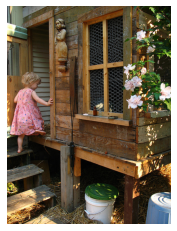

In [ ]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data Cleaning

In [ ]:
 def clean_text(sentence):
        sentence = sentence.lower()
        sentence = re.sub("[^a-z]+"," ",sentence) #not aplhabet, one or more occ
        sentence = sentence.split()
        
        sentence = [s for s in sentence if len(s)>1]
        sentence = " ".join(sentence)
        return sentence
        

In [ ]:
clean_text("My name is Pallavi and I am in third year studying Data science")

'my name is pallavi and am in third year studying data science'

In [ ]:
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [ ]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [ ]:
# write data to text file
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

### Vocabulary

In [ ]:
f = open("descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In [ ]:
vocab = set()
vocab.update(["hello","apple"])
vocab.update(["hello","hi"])
vocab.update(["hi"])
print(vocab)
#stores only unique elements

{'hi', 'hello', 'apple'}


In [ ]:
# finding the unique vocabulary 

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("vocab size: %d"% len(vocab))

vocab size: 8424


In [ ]:
#  ALl words in description dictionary
total_words =  []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(total_words))
print(total_words[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


In [ ]:
import collections
counter = collections.Counter(total_words)
freq_count = dict(counter)
print(freq_count)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [ ]:
#sort this dictionary according to the frequency count
sorted_freq_cnt = sorted(freq_count.items(),reverse=True,key=lambda x:x[1])

#filter
threshelod_value = 10

sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshelod_value]
total_words = [x[0] for x in sorted_freq_cnt]

In [ ]:
print(len(total_words))

1845


### Prepare train and test data

In [ ]:
train_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [ ]:
train  = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test  = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [ ]:
# create train_descriptions dictionary, which will be similar to earlier one, but having only train samples
# add <s> + <e> token to train data 

train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [ ]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning

#### Step1 Image Feature Extraction

In [ ]:
model = ResNet50(weights='imagenet',input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
model_new = Model(model.input,model.layers[-2].output)

In [ ]:
def preprocess_image(img):
    img = image.load_img(img, target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


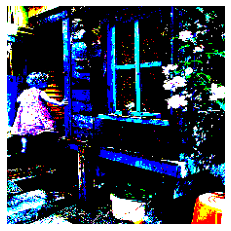

In [ ]:
img = preprocess_image(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()

In [ ]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
#     print(feature_vector.shape) ->1,2048
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

In [ ]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")


array([0.06536549, 0.16782689, 0.3251846 , ..., 0.0511154 , 0.32817915,
       1.0043331 ], dtype=float32)

In [ ]:
start = time()

encoding_train = {}

for ix, img_id in enumerate(train):
    
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)


Encoding image- 0
Encoding image- 100
Encoding image- 200
Encoding image- 300
Encoding image- 400
Encoding image- 500
Encoding image- 600
Encoding image- 700
Encoding image- 800
Encoding image- 900
Encoding image- 1000
Encoding image- 1100
Encoding image- 1200
Encoding image- 1300
Encoding image- 1400
Encoding image- 1500
Encoding image- 1600
Encoding image- 1700
Encoding image- 1800
Encoding image- 1900
Encoding image- 2000
Encoding image- 2100
Encoding image- 2200
Encoding image- 2300
Encoding image- 2400
Encoding image- 2500
Encoding image- 2600
Encoding image- 2700
Encoding image- 2800
Encoding image- 2900
Encoding image- 3000
Encoding image- 3100
Encoding image- 3200
Encoding image- 3300
Encoding image- 3400
Encoding image- 3500
Encoding image- 3600
Encoding image- 3700
Encoding image- 3800
Encoding image- 3900
Encoding image- 4000
Encoding image- 4100
Encoding image- 4200
Encoding image- 4300
Encoding image- 4400
Encoding image- 4500
Encoding image- 4600
Encoding image- 4700
Enco

In [ ]:
#store and retrieve data from disk
with open("encoded_train_features.pkl",'wb') as f:
    pickle.dump(encoding_train,f)

In [ ]:
start = time()

encoding_test = {}

for ix, img_id in enumerate(test):

    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding test image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Encoding test image- 0
Encoding test image- 100
Encoding test image- 200
Encoding test image- 300
Encoding test image- 400
Encoding test image- 500
Encoding test image- 600
Encoding test image- 700
Encoding test image- 800
Encoding test image- 900
Time taken in seconds = 290.00858449935913


In [ ]:
#store and retrieve test data from disk
with open("encoded_test_features.pkl",'wb') as f:
    pickle.dump(encoding_test,f)

In [ ]:
with open("encoded_train_features.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

# Load the test images features from disk

with open("encoded_test_features.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

In [ ]:
encoding_train

{'2513260012_03d33305cf': array([0.3470795 , 0.51159084, 0.08728848, ..., 1.1897296 , 0.04043847,
        0.1527106 ], dtype=float32),
 '2903617548_d3e38d7f88': array([0.        , 0.00307795, 0.09360035, ..., 0.43103424, 0.37985295,
        0.91657585], dtype=float32),
 '3338291921_fe7ae0c8f8': array([0.7674472 , 0.5342269 , 0.38325197, ..., 0.02098639, 0.18429385,
        0.04270015], dtype=float32),
 '488416045_1c6d903fe0': array([6.2481058e-01, 3.2965460e-01, 1.7821058e-04, ..., 1.2753810e+00,
        4.6392566e-01, 4.9036074e-01], dtype=float32),
 '2644326817_8f45080b87': array([0.1155531 , 0.6596539 , 0.05323281, ..., 0.14397353, 1.0179375 ,
        0.00556583], dtype=float32),
 '218342358_1755a9cce1': array([1.7061832 , 0.4051473 , 0.35206553, ..., 0.29408896, 0.04833031,
        0.04654434], dtype=float32),
 '2501968935_02f2cd8079': array([0.10608297, 1.4420797 , 0.04447002, ..., 0.20587179, 0.6978754 ,
        1.590432  ], dtype=float32),
 '2699342860_5288e203ea': array([0.4612

#### Step-2 Pre-Processing Captions

In [ ]:
len(total_words)

1845

In [ ]:
"""
word_to_idx is mapping between each unique word in all_vocab to int value 
and idx_to_word is vice-versa
"""

word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1 
    idx_to_word[i+1] = word
  

In [ ]:
word_to_idx["dog"]

6

In [ ]:
len(idx_to_word)

1845

In [ ]:
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab size",vocab_size)

Vocab size 1848


In [ ]:
#find out maxlength of caption
#it will be requires to make a fixed length vector


all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


In [ ]:
with open('word_to_idx.pkl','wb') as v2i:
    pickle.dump(word_to_idx,v2i)

with open('idx_to_word.pkl','wb') as i2v:
    pickle.dump(idx_to_word,i2v)

## Data Generator

In [ ]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]
                    
                    #0 denotes padding word
                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([np.array(X1), np.array(X2)], np.array(y))
                X1, X2, y = [], [], []
                n=0

### Word Embeddings

In [ ]:
f = open("glove.6B.50d.txt", encoding='utf8')

In [ ]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()


In [ ]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output

In [ ]:
embedding_matrix = get_embedding_output()
embedding_matrix.shape

(1848, 50)

In [ ]:
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

### Model Architecture

In [ ]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [ ]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [ ]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
______________________________________________________________________________________________

In [ ]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

### Train of Model

In [ ]:
epochs = 10
batch_size = 3
steps = len(train_descriptions)//batch_size

In [ ]:
#train
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

C:\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


  15/2000 [..............................] - ETA: 8:41 - loss: 2.6859

KeyboardInterrupt: 

In [ ]:
model = load_model("./model_weights/model_9.h5")

### Predictions

In [ ]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #words with max prob always- greedy sampling
        word = idx_to_word[ypred]
        in_text += (' '+word)
        
        if word == 'endseq':
            break
            
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

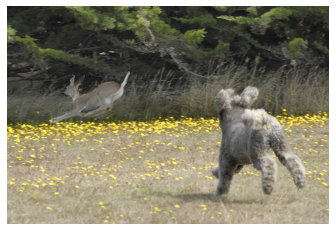

two dogs are running through field


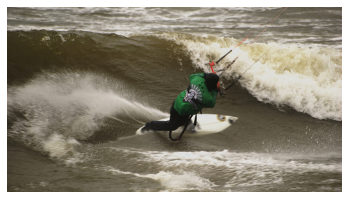

surfer rides wave


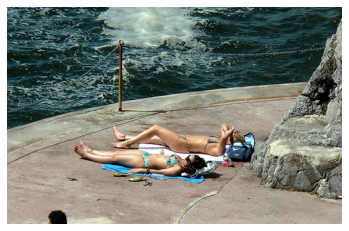

man in bathing suit is jumping off rock


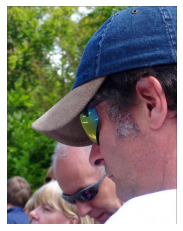

man with facial and his hand and his hand


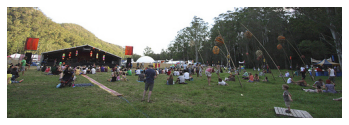

group of people are riding horses


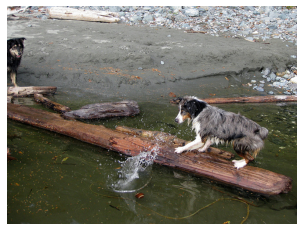

dog is jumping into the water


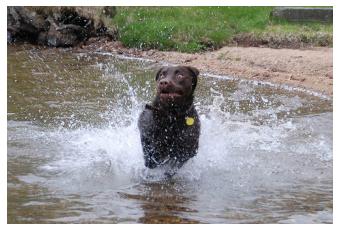

black dog is running through the water


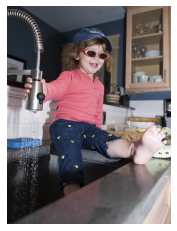

little girl in pajamas is sitting on the lap


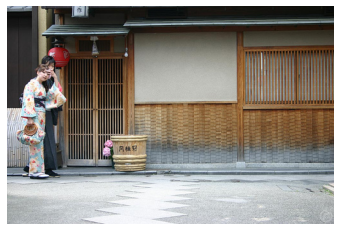

man in blue shirt is standing on the sidewalk


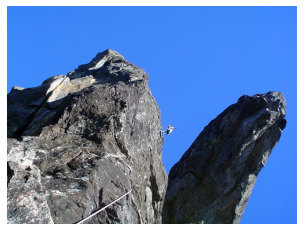

man climbing up rocky cliff


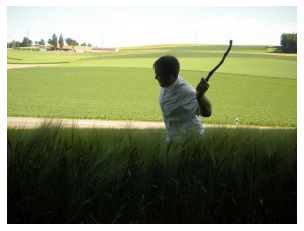

little girl in blue shirt and denim shorts plays with ball


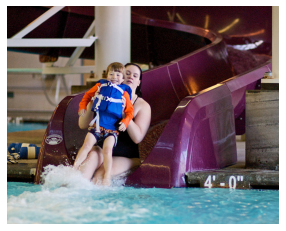

young boy in red shirt is jumping into pool


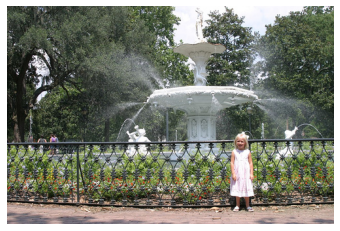

little girl in green shirt and jeans is jumping on chain swing


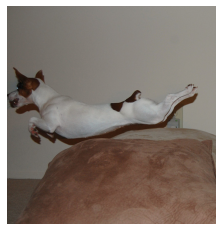

little girl in pink bathing suit is jumping on bed


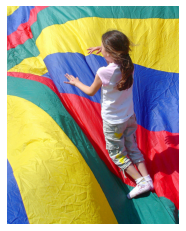

little boy in spiderman shirt is jumping into the air


In [ ]:
#pick random images
for i in range(15):
    idx = np.random.randint(1,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("Data/Images/"+img_name+'.jpg')
    caption = predict_caption(photo_2048)
    plt.imshow(i)
    plt.axis('off')
    plt.show()
    print(caption)

    